In [1]:
import os
import numpy as np
import pandas as pd

import scanpy as sc
import decoupler as dc
import liana as li
import squidpy as sq

import muon as mu

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from scipy.sparse import csr_matrix

In [3]:
data_dir = os.path.join('..', '..', 'data', 'heart_visium')

In [4]:
dataset_names = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

In [5]:
metadata = pd.read_csv(os.path.join("..", "spot_calling", "visium_meta.csv"))

In [6]:
# get IZ samples
metadata = metadata[metadata['major_labl']=='IZ']

Pick this: 	Visium_7_CK285

In [7]:
metadata

slide_name patient patient_region_id patient_group major_labl batch  \
1     AKK002_157779      P3             IZ_P3       group_2         IZ   10X   
4     AKK003_157775      P2          IZ/BZ_P2       group_2         IZ   10X   
10  Visium_11_CK289     P13         GT/IZ_P13       group_2         IZ   ACH   
14  Visium_15_CK293     P16            IZ_P16       group_2         IZ   ACH   
17  Visium_18_CK296     P15         GT/IZ_P15       group_2         IZ   ACH   
18  Visium_19_CK297      P9     GT/IZ_P9_rep2       group_2         IZ   ACH   
20  Visium_20_CK298     P15            IZ_P15       group_2         IZ   ACH   
25   Visium_7_CK285     P10            IZ_P10       group_2         IZ   ACH   
27   Visium_9_CK287      P9          GT/IZ_P9       group_2         IZ   ACH   

   hca_sample_id  
1        10X0017  
4        10X0018  
10       ACH0010  
14       ACH0016  
17       ACH0011  
18       ACH0013  
20       ACH0015  
25       ACH0014  
27       ACH0012

In [8]:
# load collecTRI regulons
net = dc.get_dorothea(organism='human')

In [9]:
sc.set_figure_params(fontsize=16, figsize=(8, 8), frameon=False)

Read in H loadings from NMF

In [10]:
selected_factor = 'Factor1'

In [11]:
lr_loadings = pd.read_csv(os.path.join("results", "lr_loadings.csv"), index_col=0)

In [12]:
lr_loadings.sort_values(selected_factor, ascending=False).head(10)

Factor1   Factor2   Factor3   Factor4
SPP1^ITGA5_ITGB1     5.467238  0.000000  0.000000  0.388341
SPP1^CD44            5.177995  0.000000  0.000000  0.587471
SPP1^ITGAV_ITGB1     5.129260  0.250505  0.141072  0.371158
TNC^ITGA5            4.963801  0.181118  0.215097  0.166645
NAMPT^ITGA5_ITGB1    4.779194  0.000000  0.996638  0.487486
COL4A1^CD44          4.305247  0.182576  0.921232  0.927527
VCAN^CD44            4.287526  0.336375  0.534389  0.859732
PKM^CD44             4.281227  0.094112  1.091048  0.924720
ANGPTL4^ITGA5_ITGB1  4.241927  0.321677  0.000000  0.148310
PLAU^ITGB1           4.238058  0.391381  0.086665  0.180097

<AxesSubplot:>

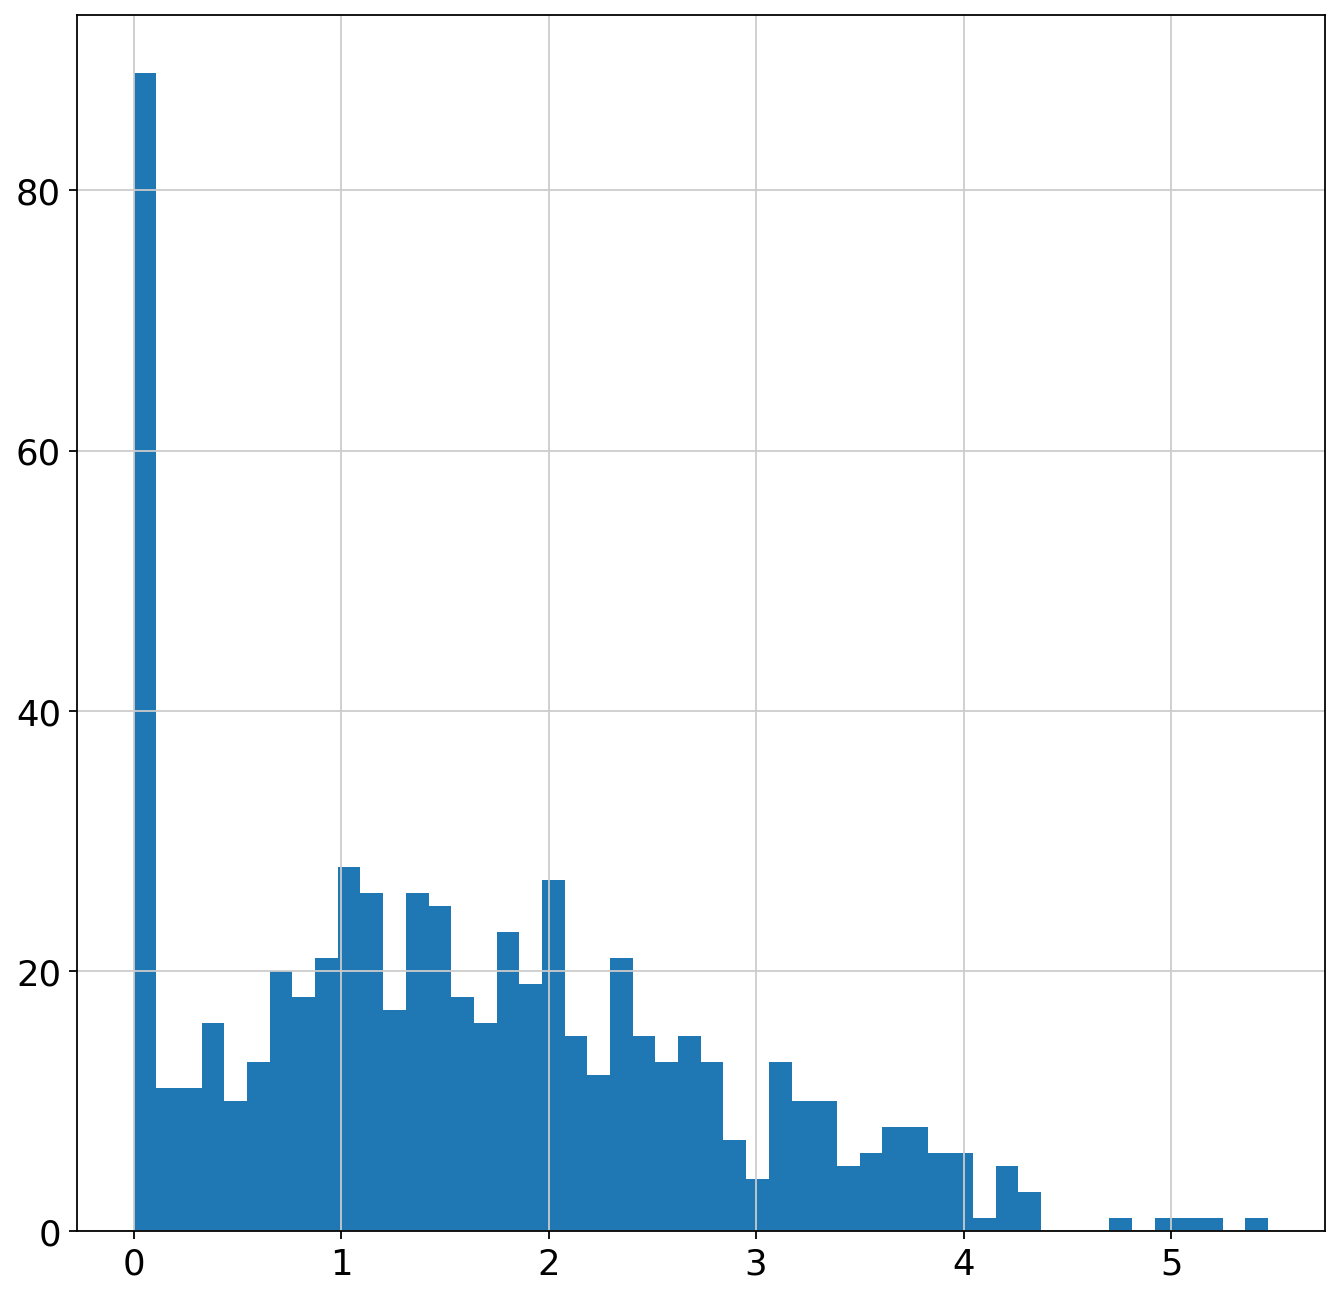

In [13]:
# histogram
lr_loadings[selected_factor].hist(bins=50, figsize=(10, 10))

In [14]:
top_features = lr_loadings.sort_values(selected_factor, ascending=False).head(20).index

In [15]:
top_features

Index(['SPP1^ITGA5_ITGB1', 'SPP1^CD44', 'SPP1^ITGAV_ITGB1', 'TNC^ITGA5',
       'NAMPT^ITGA5_ITGB1', 'COL4A1^CD44', 'VCAN^CD44', 'PKM^CD44',
       'ANGPTL4^ITGA5_ITGB1', 'PLAU^ITGB1', 'FN1^CD44', 'COL4A2^CD44',
       'VIM^CD44', 'SPP1^ITGAV_ITGB5', 'FN1^ITGA5_ITGB1', 'TNC^ITGA7',
       'COL6A1^CD44', 'CALR^ITGA3', 'COL6A2^CD44', 'PLAU^ITGA5'],
      dtype='object')

Load files, join to MuData

In [16]:
mdatas = {}
target_metrics = {}
interactions = {}

for sample in metadata['slide_name']:
    print(f"Now running: {sample}")
    
    lr = sc.read_h5ad(os.path.join('results', 'lr', sample + '.h5ad'))
    msk = lr.var.index[lr.var_names.isin(top_features)]
    lr = lr[:, msk]
    
    # li.ut.spatial_neighbors(adata, bandwidth=100, set_diag=False, cutoff=0.01)
    
    # run TF enrichment
    adata = sc.read_h5ad(os.path.join('results', 'processed', sample + '.h5ad'))
    dc.run_ulm(adata,
               net,
               source="source", target="target",
               use_raw=False, min_n=5)
    tf = li.ut.obsm_to_adata(adata, 'ulm_estimate')
    # exract compositions
    comp = li.ut.obsm_to_adata(adata, 'compositions')
    
    # Build misty views and run MISTy
    mdata = mu.MuData({"intra": lr.copy(), "comp":comp.copy(), "tf":tf.copy()})
    mu.pp.intersect_obs(mdata)
    misty = li.mt.MistyData(mdata)
    misty(model='linear', verbose=True, bypass_intra=True)
    
    target_metrics[sample] = misty.uns['target_metrics']
    interactions[sample] = misty.uns['interactions']
    
    mdatas[sample] = mdata

Now running: AKK002_157779


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:37<00:00,  1.85s/it]          


Now running: AKK003_157775


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]          


Now running: Visium_11_CK289


Now learning: TNC^ITGA7: 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]          


Now running: Visium_15_CK293


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]          


Now running: Visium_18_CK296


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]          


Now running: Visium_19_CK297


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]          


Now running: Visium_20_CK298


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]          


Now running: Visium_7_CK285


Now learning: TNC^ITGA7: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]        


Now running: Visium_9_CK287


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]          


In [17]:
targets = pd.concat(target_metrics).reset_index().rename(columns={'level_0':'sample'}).drop(columns='level_1').copy()
targets.to_csv(os.path.join("results", "misty_targets.csv"))

In [18]:
ints = pd.concat(interactions).reset_index().rename(columns={'level_0':'sample'}).drop(columns='level_1').copy()
ints.to_csv(os.path.join("results", "misty_interactions.csv"))

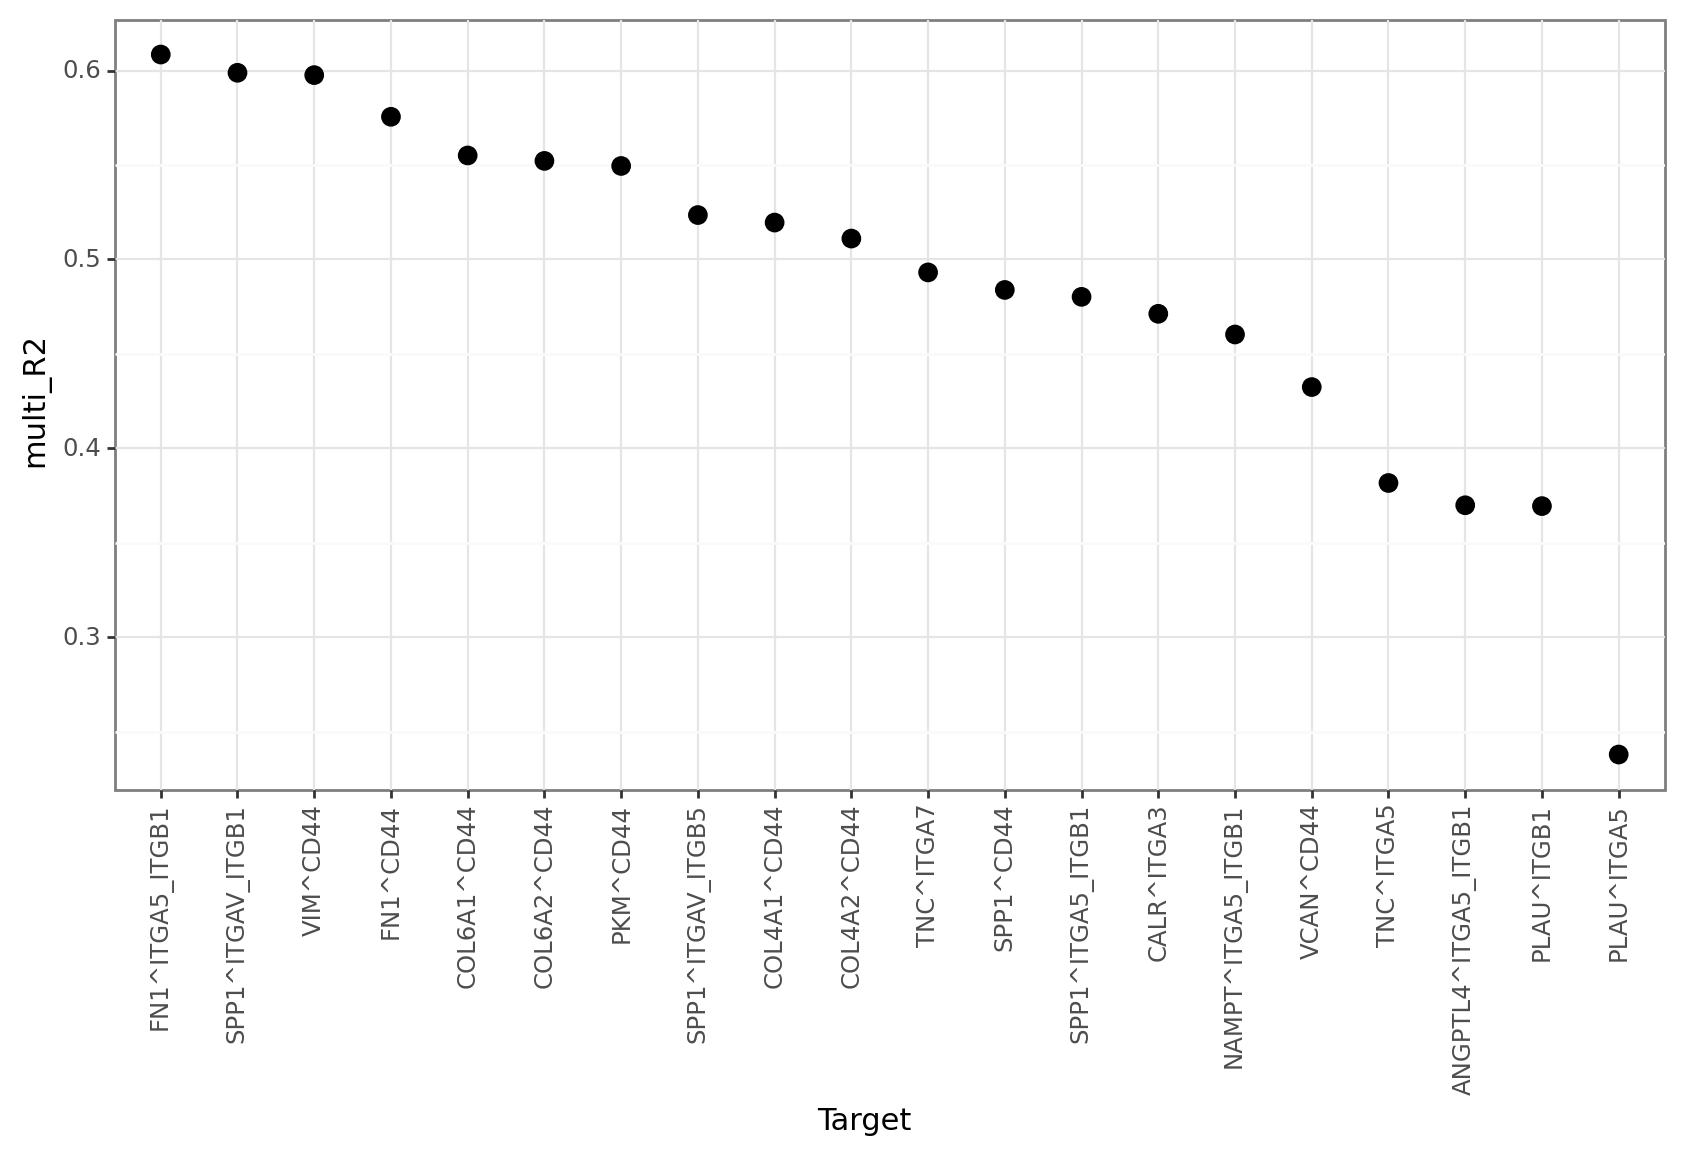

<ggplot: (8755626111301)>

In [19]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True, figure_size=(10, 5))

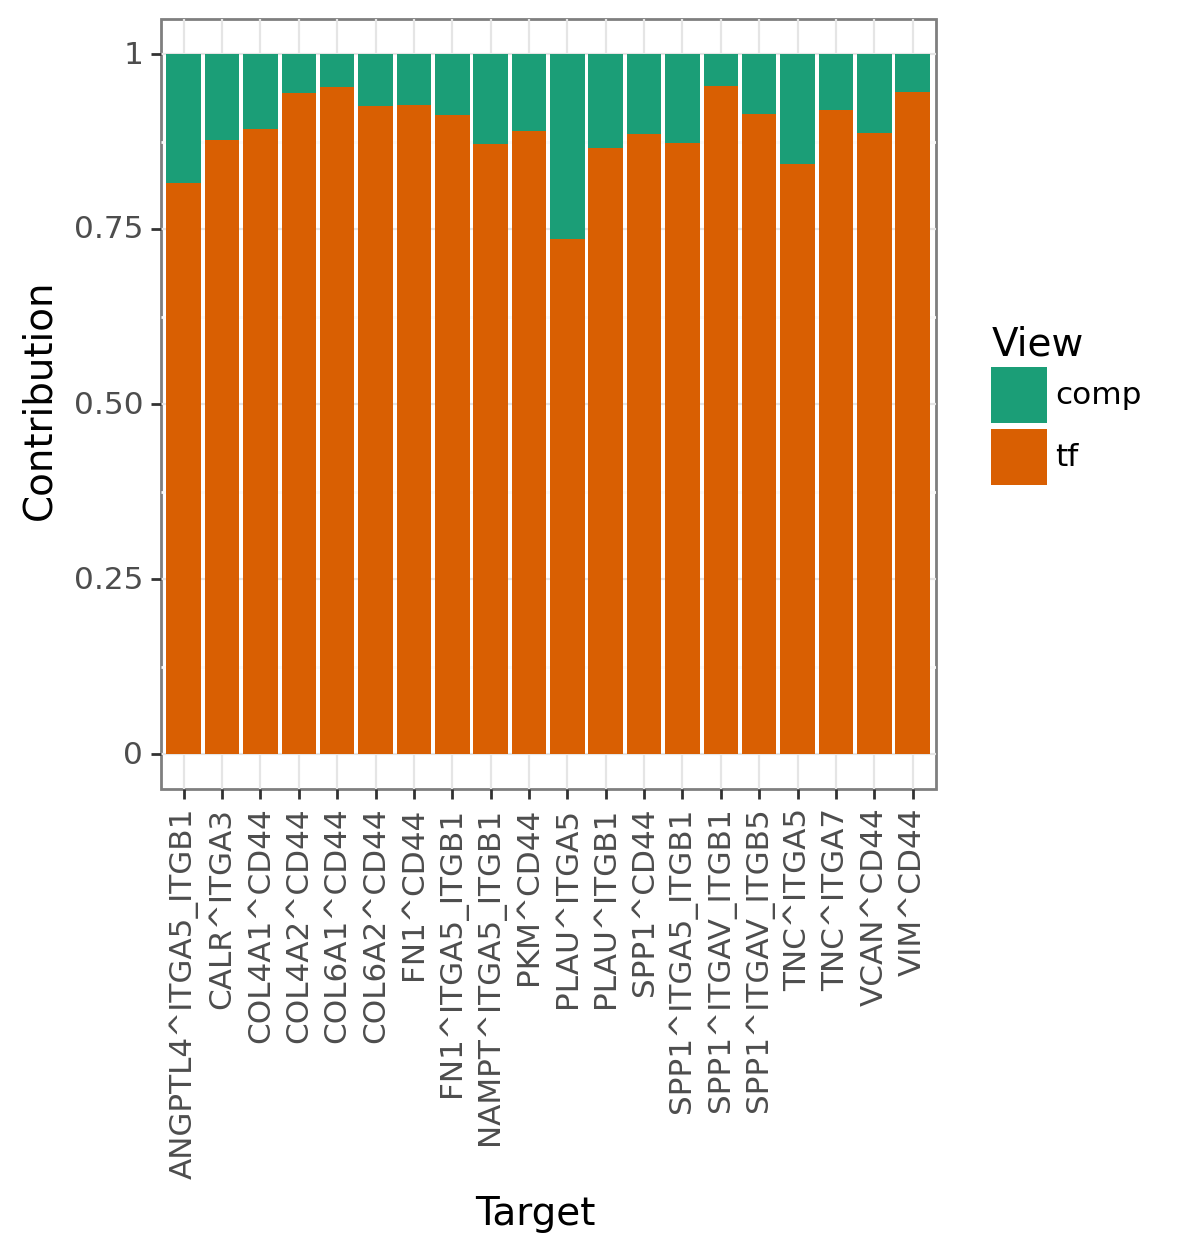

<ggplot: (8755620320410)>

In [20]:
li.pl.contributions(misty, return_fig=True, figure_size=(5, 5))

In [21]:
interactions = misty.uns['interactions'].copy()

In [22]:
interactions[interactions['view']=='tf'].sort_values("importances", ascending=False, key=lambda x: abs(x)).head(15)

target predictor view  importances
9850     FN1^ITGA5_ITGB1      PAX6   tf    22.794113
6599            FN1^CD44    TCF7L2   tf    18.306597
8411            VIM^CD44    TCF7L2   tf    18.126715
6297         COL4A1^CD44    TCF7L2   tf    17.962008
7505         COL6A2^CD44    TCF7L2   tf    17.342342
7203         COL6A1^CD44    TCF7L2   tf    16.837925
8713            PKM^CD44    TCF7L2   tf    15.890687
10756  NAMPT^ITGA5_ITGB1      PAX6   tf    14.833329
6596            FN1^CD44      TCF4   tf    14.240582
8408            VIM^CD44      TCF4   tf    12.996432
6901         COL4A2^CD44    TCF7L2   tf    12.833933
7502         COL6A2^CD44      TCF4   tf    11.834496
11093   SPP1^ITGAV_ITGB1     SMAD1   tf    11.683603
8951          PLAU^ITGB1    POU2F1   tf    11.392240
7200         COL6A1^CD44      TCF4   tf    11.009774

Plot sample averages

In [23]:
import plotnine as p9

In [24]:
ints = pd.read_csv(os.path.join("results", "misty_interactions.csv"), index_col=0)
targets = pd.read_csv(os.path.join("results", "misty_targets.csv"), index_col=0)

Contributions

In [25]:
contributions = targets[['target', 'tf', 'comp', 'sample']].melt(id_vars=['target', 'sample'], var_name='view', value_name='contribution').copy()

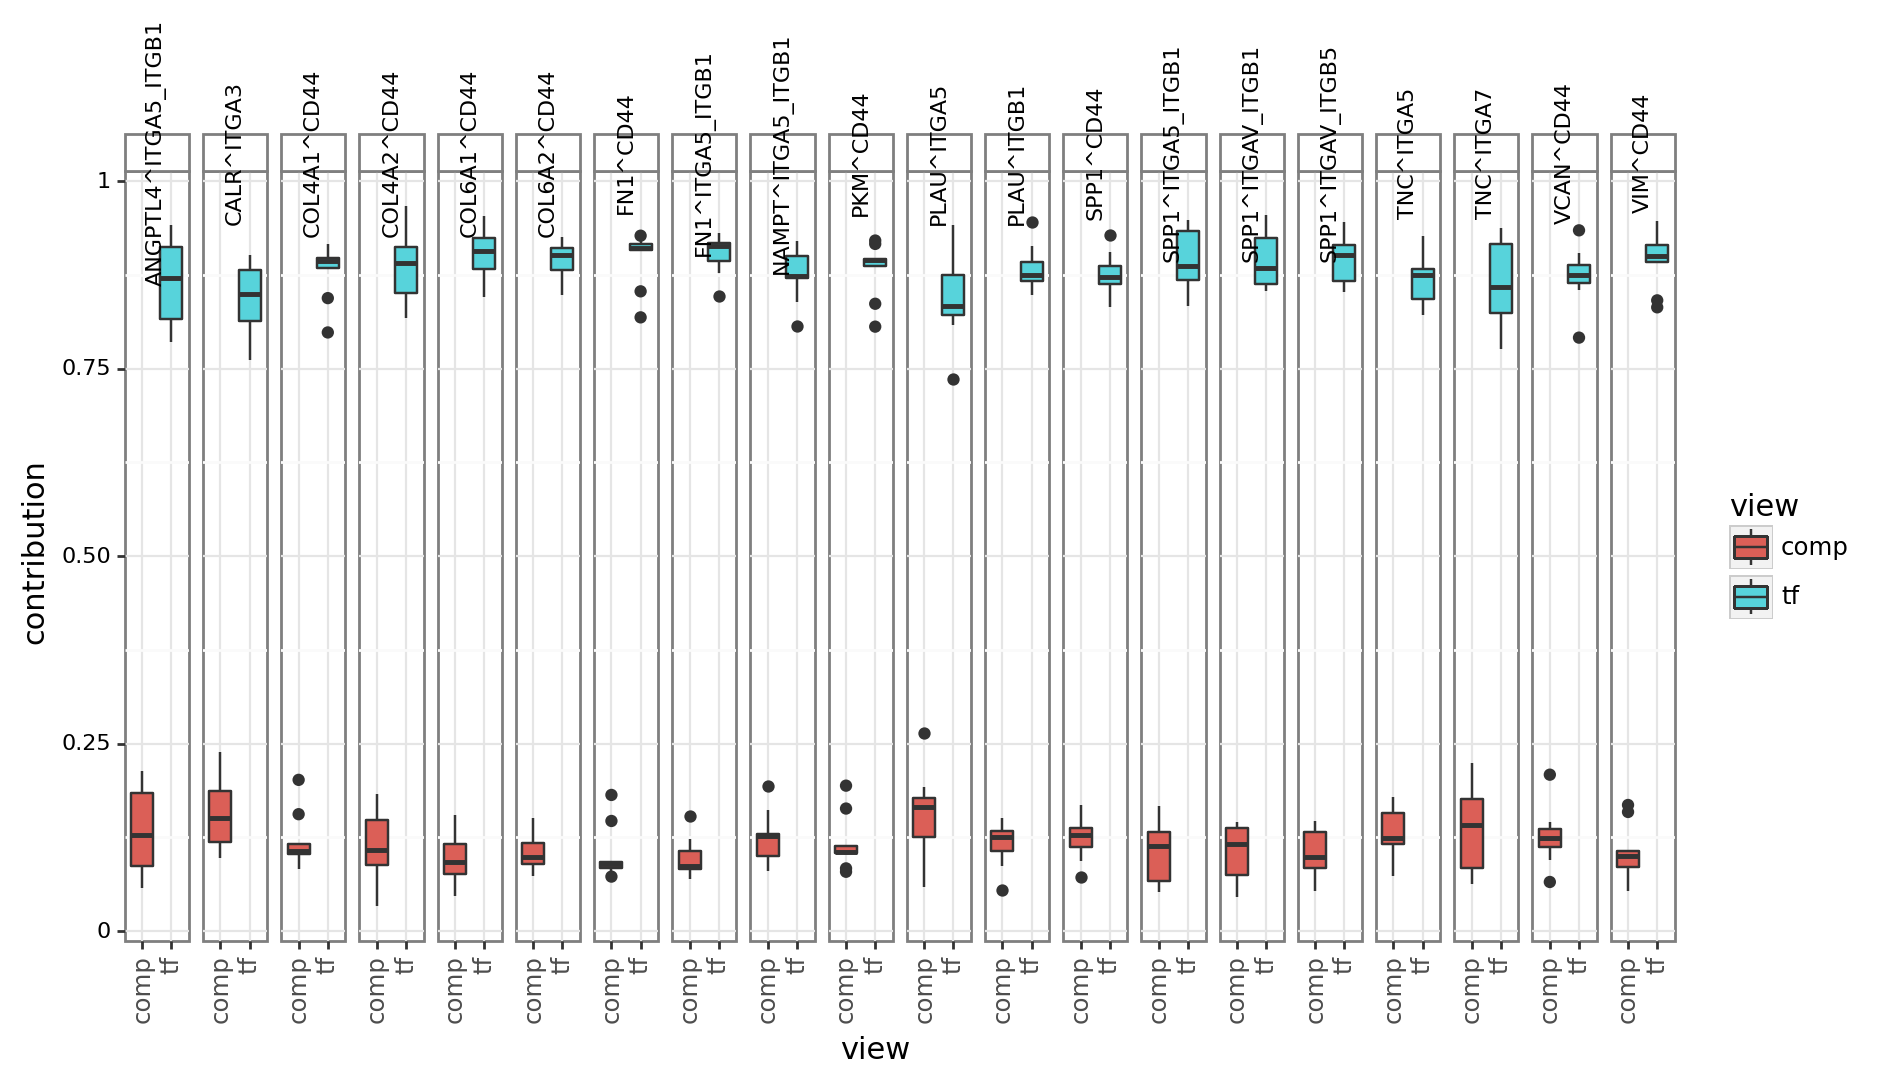

<ggplot: (8755664152549)>

In [26]:
### boxplot, ~target, x=view, y=contribution

(
    p9.ggplot(contributions, p9.aes(x='view', y='contribution', fill='view')) +
    p9.geom_boxplot() +
    p9.facet_wrap('~ target', nrow=1) +
    p9.theme_bw() +
    p9.theme(axis_text_x=p9.element_text(rotation=90),
             figure_size=(10, 5),
             strip_background=p9.element_rect(fill="white"),
             strip_text=p9.element_text(size=8, colour="black", rotation=90),
             axis_text_y=p9.element_text(size=8, colour="black"),
             )
    # flip coord
)


#### R2 multi

In [27]:
targets

sample             target  intra_R2  multi_R2   gain_R2  \
0     AKK002_157779        COL4A1^CD44         0  0.757645  0.757645   
1     AKK002_157779           FN1^CD44         0  0.730101  0.730101   
2     AKK002_157779        COL4A2^CD44         0  0.713675  0.713675   
3     AKK002_157779        COL6A1^CD44         0  0.732709  0.732709   
4     AKK002_157779        COL6A2^CD44         0  0.699981  0.699981   
..              ...                ...       ...       ...       ...   
173  Visium_9_CK287  NAMPT^ITGA5_ITGB1         0  0.460303  0.460303   
174  Visium_9_CK287   SPP1^ITGAV_ITGB1         0  0.598817  0.598817   
175  Visium_9_CK287         CALR^ITGA3         0  0.471257  0.471257   
176  Visium_9_CK287   SPP1^ITGAV_ITGB5         0  0.523522  0.523522   
177  Visium_9_CK287          TNC^ITGA7         0  0.493161  0.493161   

         comp        tf  
0    0.094669  0.905331  
1    0.089423  0.910577  
2    0.087671  0.912329  
3    0.076544  0.923456  
4    0.098435  0.901565  
..        ...       ...  
173  0.127794  0.872206  
174  0.045111  0.954889  
175  0.122273  0.877727  
176  0.084974  0.915026  
177  0.078885  0.921115  

[178 rows x 7 columns]

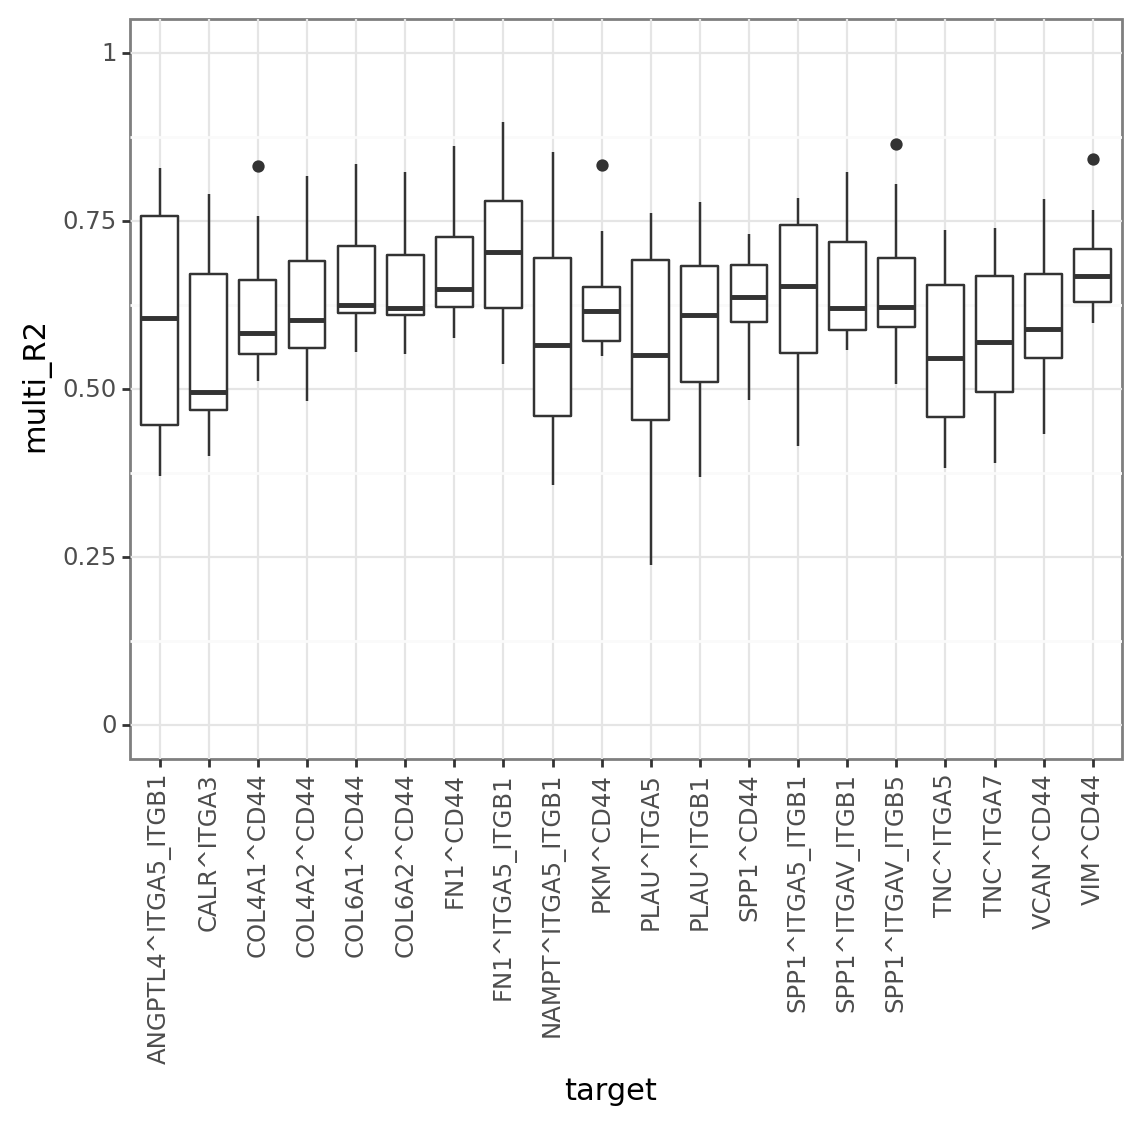

<ggplot: (8755664249766)>

In [28]:
# boxplot of y=multi_R2, x=target
(
    p9.ggplot(targets, p9.aes(x='target', y='multi_R2')) +
    p9.geom_boxplot() +
    p9.theme_bw() +
    p9.theme(axis_text_x=p9.element_text(rotation=90)) +
    # limits of y
    p9.ylim(0, 1)
    
) 

In [29]:
targets.groupby('target').mean().sort_values('multi_R2', ascending=False).head(10)

/tmp/ipykernel_664511/3918919098.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


intra_R2  multi_R2   gain_R2      comp        tf
target                                                            
FN1^ITGA5_ITGB1        0.0  0.706260  0.706260  0.097461  0.902539
VIM^CD44               0.0  0.683388  0.683388  0.106662  0.893338
FN1^CD44               0.0  0.675101  0.675101  0.102984  0.897016
COL6A1^CD44            0.0  0.658901  0.658901  0.095682  0.904318
SPP1^ITGAV_ITGB1       0.0  0.657609  0.657609  0.106873  0.893127
SPP1^ITGAV_ITGB5       0.0  0.656053  0.656053  0.104511  0.895489
COL6A2^CD44            0.0  0.652384  0.652384  0.105787  0.894213
PKM^CD44               0.0  0.637722  0.637722  0.117443  0.882557
SPP1^ITGA5_ITGB1       0.0  0.631989  0.631989  0.106789  0.893211
SPP1^CD44              0.0  0.626931  0.626931  0.122271  0.877729

## Plot Averages across slides

In [30]:
interaction = 'FN1^ITGA5_ITGB1'

In [31]:
ints.sort_values("importances")

sample       target predictor  view  importances
6078     AKK003_157775     VIM^CD44        CM  comp   -30.872477
6023     AKK003_157775  COL4A2^CD44        CM  comp   -30.601463
6067     AKK003_157775    VCAN^CD44        CM  comp   -28.899786
6001     AKK003_157775  COL4A1^CD44        CM  comp   -28.733868
6012     AKK003_157775     FN1^CD44        CM  comp   -28.375376
...                ...          ...       ...   ...          ...
29750  Visium_19_CK297  COL6A2^CD44       Fib  comp    50.319870
29739  Visium_19_CK297  COL6A1^CD44       Fib  comp    50.589817
29717  Visium_19_CK297     FN1^CD44       Fib  comp    50.721947
29783  Visium_19_CK297     VIM^CD44       Fib  comp    52.585308
29794  Visium_19_CK297     PKM^CD44       Fib  comp    53.543983

[53562 rows x 5 columns]

In [32]:
### boxplot of tf view
sum_ints = ints.dropna().copy()

In [33]:
# mean and std
sum_ints = sum_ints.groupby(['target', 'view', 'predictor']).agg({'importances':['mean', 'std', 'median']}).reset_index()
# reset names
sum_ints.columns = ['target', 'view', 'predictor', 'mean', 'std', 'median']

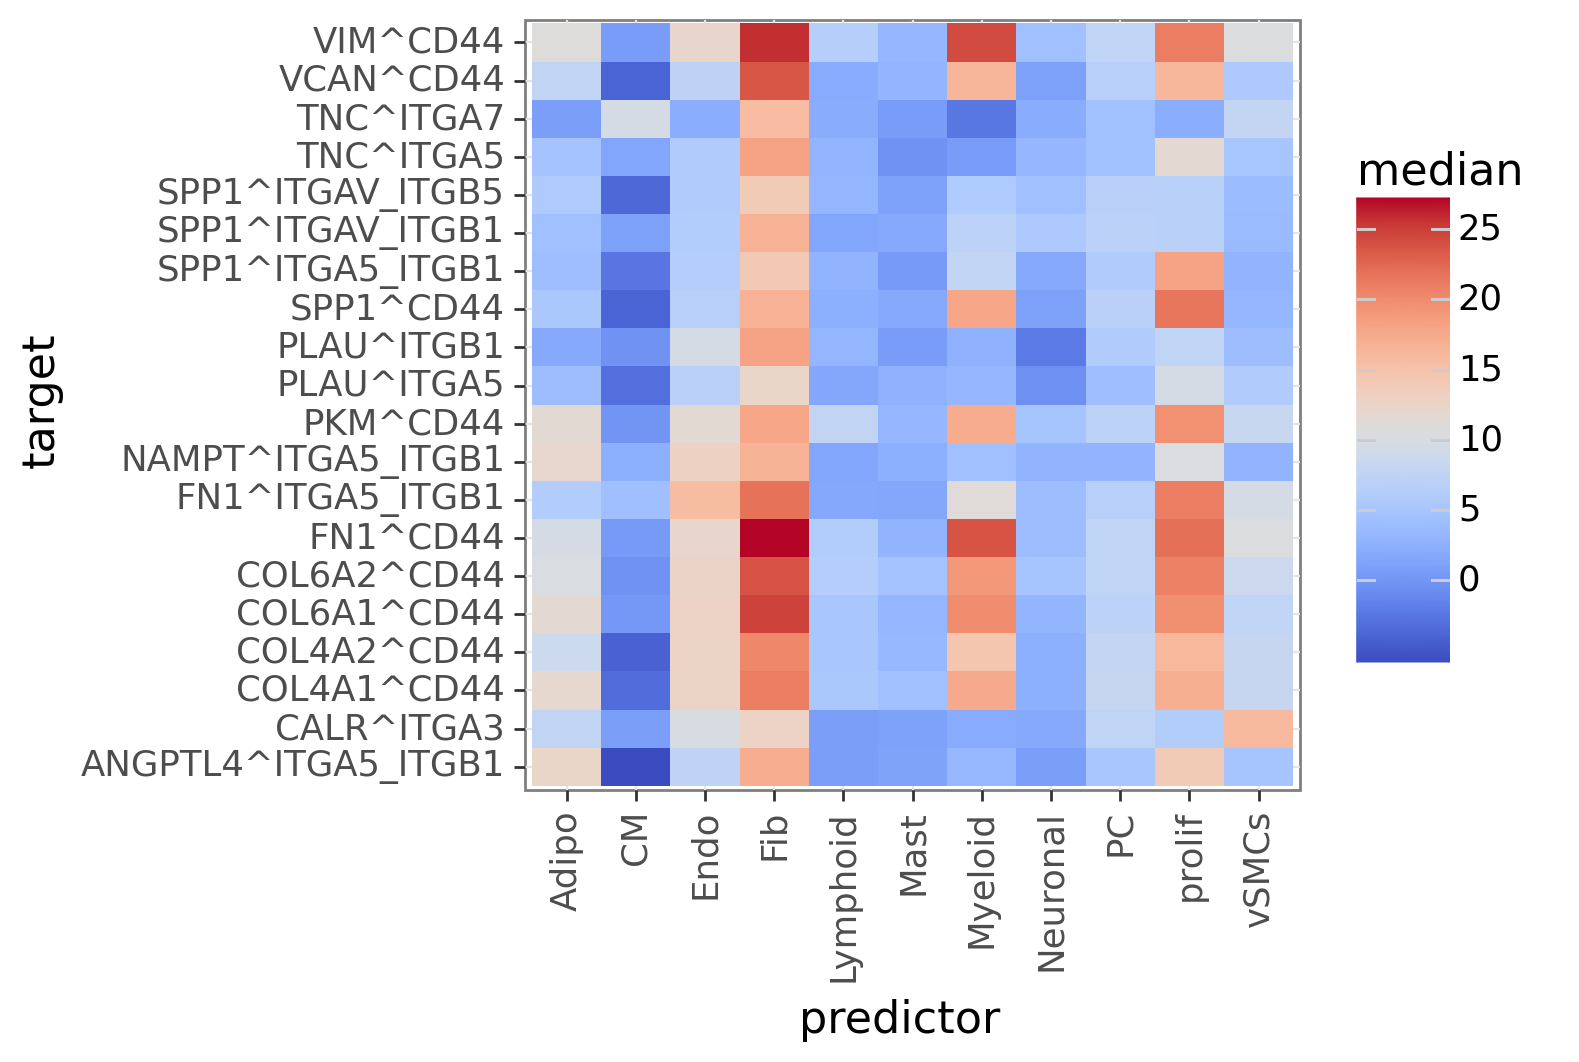

<ggplot: (8755664155456)>

In [34]:
# heatmap
(
    p9.ggplot(sum_ints[(sum_ints['view']=='comp')], p9.aes(x='predictor', y='target', fill='median')) + 
    p9.geom_tile() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90)) +
    p9.scale_fill_cmap('coolwarm') +
    p9.theme(figure_size=(5, 5))
)

Top TFs

In [35]:
top_predictors = sum_ints[sum_ints['target']==interaction].sort_values('median', ascending=False, key=abs)
top_predictors.head(30)

target  view predictor       mean        std     median
2138  FN1^ITGA5_ITGB1  comp       Fib  24.268688  10.356254  21.335171
2144  FN1^ITGA5_ITGB1  comp    prolif  16.039578  13.516681  20.482697
2323  FN1^ITGA5_ITGB1    tf      PAX6  16.584521   3.984619  15.800350
2137  FN1^ITGA5_ITGB1  comp      Endo  15.089452   6.608060  15.403190
2141  FN1^ITGA5_ITGB1  comp   Myeloid  11.787640   8.090356  11.104955
2145  FN1^ITGA5_ITGB1  comp     vSMCs  11.236337   5.230299   9.839012
2143  FN1^ITGA5_ITGB1  comp        PC   6.633515   5.768894   6.747494
2135  FN1^ITGA5_ITGB1  comp     Adipo  10.051872  13.368409   6.290595
2303  FN1^ITGA5_ITGB1    tf      NFIC  -5.005864   2.625284  -4.883749
2136  FN1^ITGA5_ITGB1  comp        CM   1.874680  10.335321   4.526493
2142  FN1^ITGA5_ITGB1  comp  Neuronal   4.270325   7.456336   4.259258
2203  FN1^ITGA5_ITGB1    tf      ETS1   3.213024   1.565801   3.855219
2247  FN1^ITGA5_ITGB1    tf     HOXB7  -2.380928   0.871442  -2.501771
2371  FN1^ITGA5_ITGB1    tf       SP1   2.606374   1.402090   2.448885
2186  FN1^ITGA5_ITGB1    tf      E2F5   1.786902   2.220716   2.401714
2281  FN1^ITGA5_ITGB1    tf     MEF2A   2.172566   1.016675   2.362243
2153  FN1^ITGA5_ITGB1    tf      ATF2  -2.020027   2.373340  -2.319849
2373  FN1^ITGA5_ITGB1    tf       SP3  -1.883348   1.642336  -2.306089
2349  FN1^ITGA5_ITGB1    tf      RFX5   1.550546   2.426185   2.270446
2139  FN1^ITGA5_ITGB1  comp  Lymphoid   2.726984   5.079959   2.199457
2379  FN1^ITGA5_ITGB1    tf       SRF  -1.140300   2.439096  -2.196378
2170  FN1^ITGA5_ITGB1    tf     CEBPE  -2.140025   1.290552  -2.142197
2140  FN1^ITGA5_ITGB1  comp      Mast   1.729827   2.982782   2.006382
2193  FN1^ITGA5_ITGB1    tf      ELF3  -1.548979   2.090029  -2.001938
2178  FN1^ITGA5_ITGB1    tf     CTCFL   1.198508   2.376469   1.903963
2291  FN1^ITGA5_ITGB1    tf       MYC   1.892090   1.119624   1.881127
2312  FN1^ITGA5_ITGB1    tf     NR2F1   1.254005   1.567292   1.878376
2412  FN1^ITGA5_ITGB1    tf       VDR  -1.277398   1.813714  -1.868229
2387  FN1^ITGA5_ITGB1    tf      TAL1  -1.502694   0.778975  -1.803683
2304  FN1^ITGA5_ITGB1    tf     NFKB1  -1.101713   2.015994  -1.699979

In [36]:
top_predictors = top_predictors[top_predictors['view']=='tf'].head(30)['predictor'].unique()

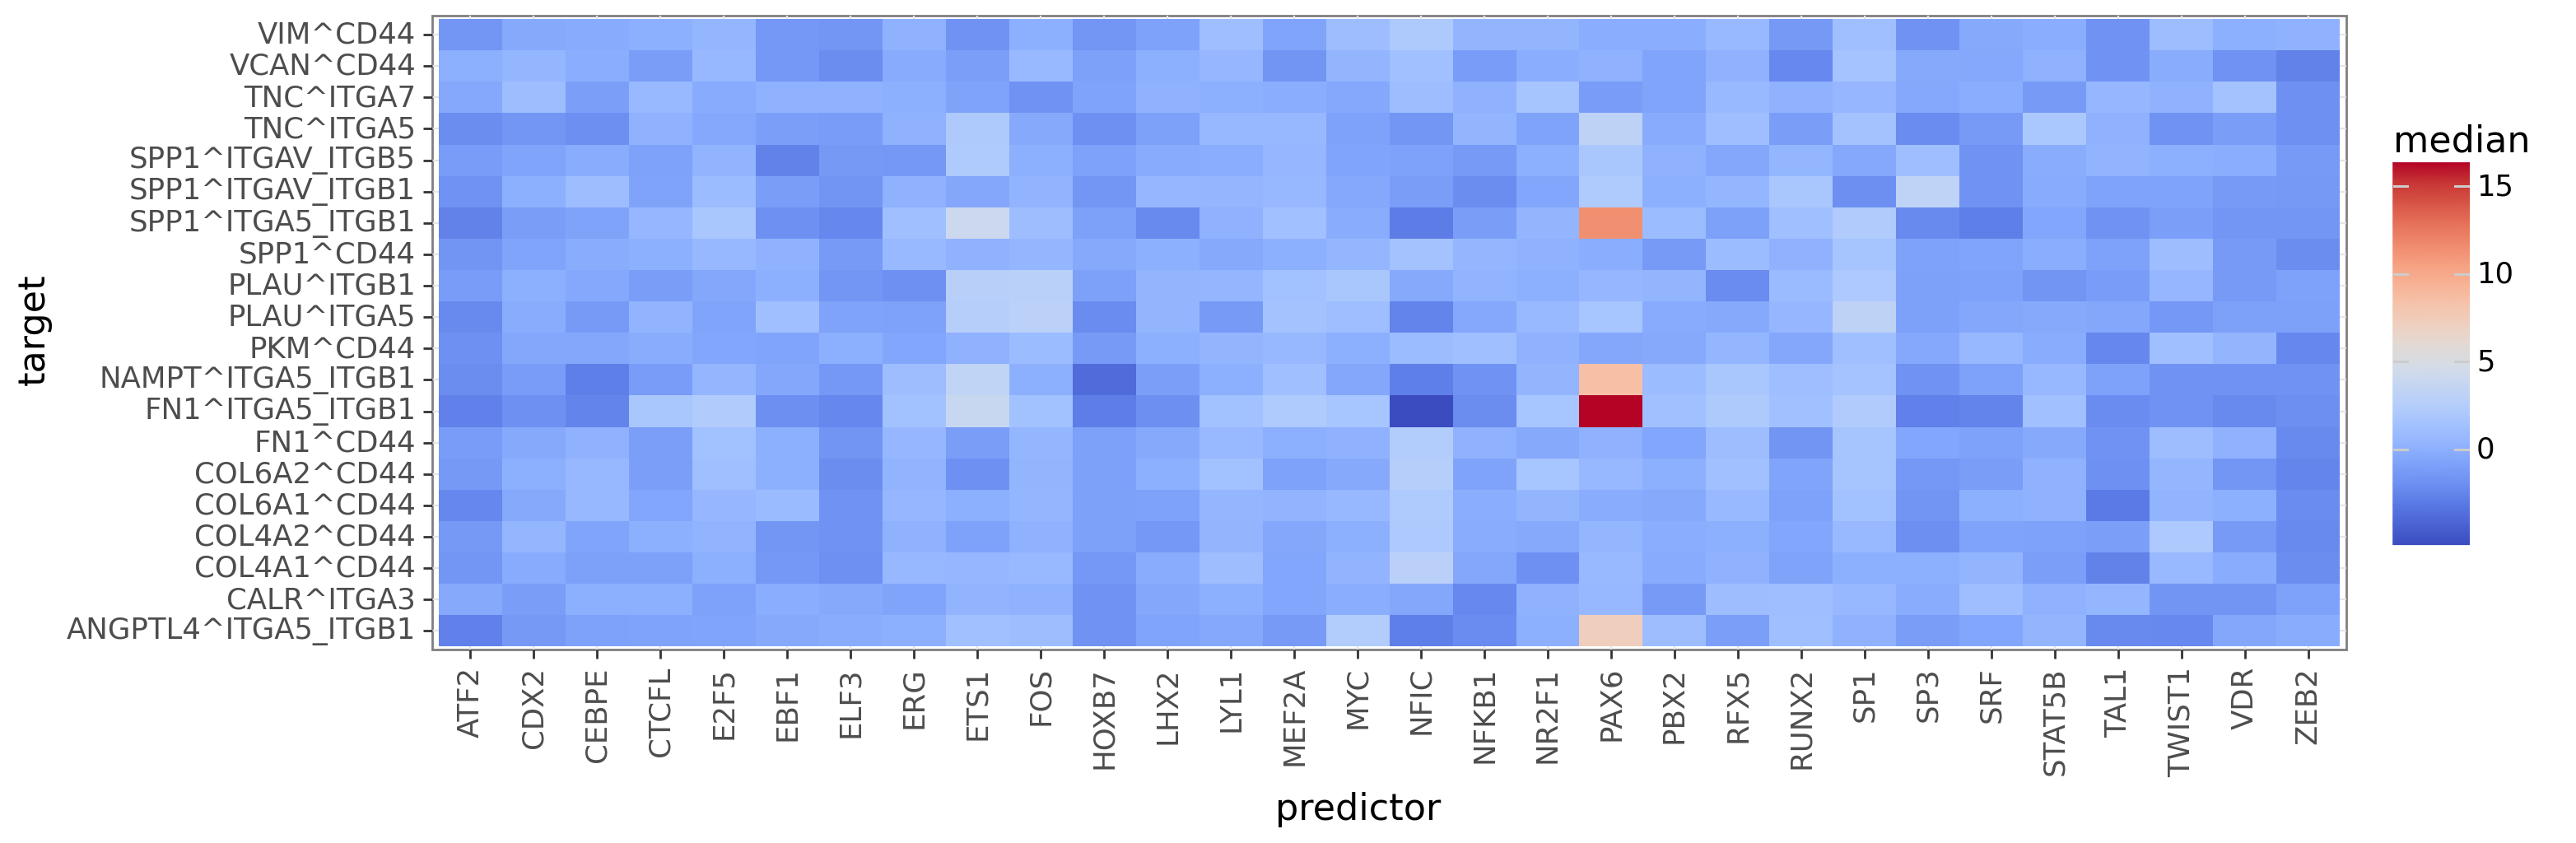

<ggplot: (8755651799284)>

In [37]:
# heatmap
(
    p9.ggplot(sum_ints[sum_ints['predictor'].isin(top_predictors)],
              p9.aes(x='predictor', y='target', fill='median')) + 
    p9.geom_tile() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90)) +
    p9.scale_fill_cmap('coolwarm') +
    p9.theme(figure_size=(15, 5))
    
)

Boxplot of top predictors for interaction x

In [38]:
top_ints = sum_ints[sum_ints['target']==interaction].sort_values("median", key=abs, ascending=False).head(15)

In [39]:
top_predictors = top_ints['predictor'].values

In [40]:
top_ints = ints[(ints['target']==interaction) & (ints['predictor'].isin(top_predictors))].copy()

In [41]:
top_ints['predictor'] = pd.Categorical(top_ints['predictor'], categories=top_predictors, ordered=True)

In [42]:
top_ints['view'].replace({'tf': 'Regulator', 'comp': 'Cell type'}, inplace=True)

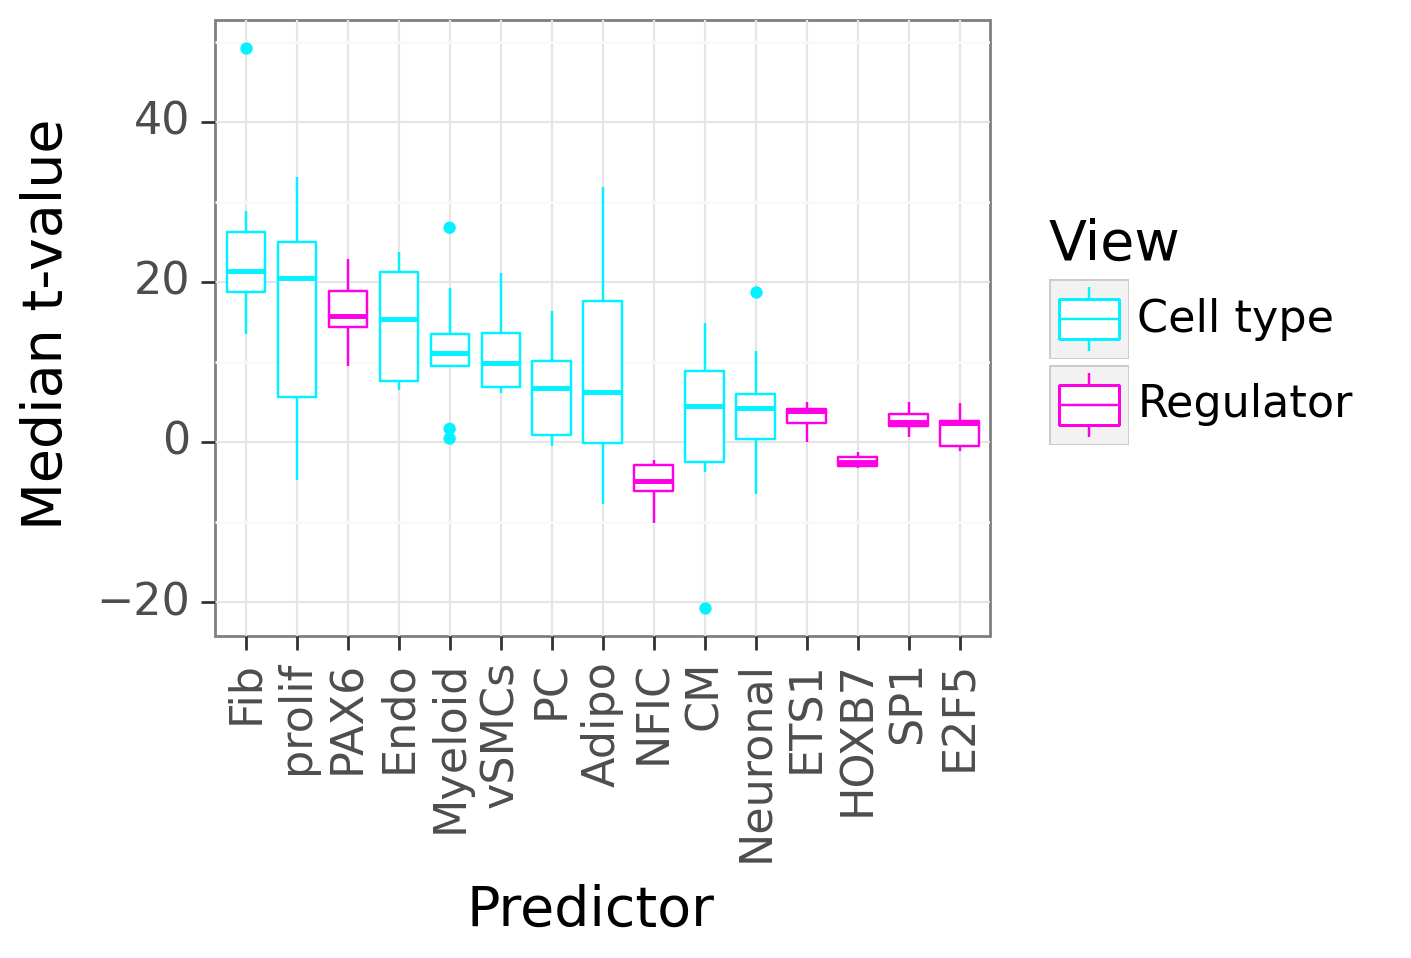

<ggplot: (8755651735456)>

In [43]:
### boxplot
(
    p9.ggplot(top_ints, p9.aes(x='predictor', y='importances', colour='view')) +
    p9.geom_boxplot() +
    p9.theme_bw(base_size = 20) +
    p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(5, 4)) +
    # labels
    p9.labs(x='Predictor', y='Median t-value', color='View') +
    # neon palette two colours
    p9.scale_colour_manual(values=['#00F3FF', '#FF00E4'])
)

In [44]:
sum_ints[sum_ints['target']==interaction].sort_values('median').tail(10)

target  view predictor       mean        std     median
2142  FN1^ITGA5_ITGB1  comp  Neuronal   4.270325   7.456336   4.259258
2136  FN1^ITGA5_ITGB1  comp        CM   1.874680  10.335321   4.526493
2135  FN1^ITGA5_ITGB1  comp     Adipo  10.051872  13.368409   6.290595
2143  FN1^ITGA5_ITGB1  comp        PC   6.633515   5.768894   6.747494
2145  FN1^ITGA5_ITGB1  comp     vSMCs  11.236337   5.230299   9.839012
2141  FN1^ITGA5_ITGB1  comp   Myeloid  11.787640   8.090356  11.104955
2137  FN1^ITGA5_ITGB1  comp      Endo  15.089452   6.608060  15.403190
2323  FN1^ITGA5_ITGB1    tf      PAX6  16.584521   3.984619  15.800350
2144  FN1^ITGA5_ITGB1  comp    prolif  16.039578  13.516681  20.482697
2138  FN1^ITGA5_ITGB1  comp       Fib  24.268688  10.356254  21.335171

Example Slide

In [45]:
mdatas.keys()

dict_keys(['AKK002_157779', 'AKK003_157775', 'Visium_11_CK289', 'Visium_15_CK293', 'Visium_18_CK296', 'Visium_19_CK297', 'Visium_20_CK298', 'Visium_7_CK285', 'Visium_9_CK287'])

In [46]:
slide = 'AKK003_157775'
comp = 'Fib'
tf = 'PAX6'
interaction = 'FN1^ITGA5_ITGB1'
xy_sep = "<->"

In [47]:
import re

In [48]:
mdata = mdatas[slide].copy()

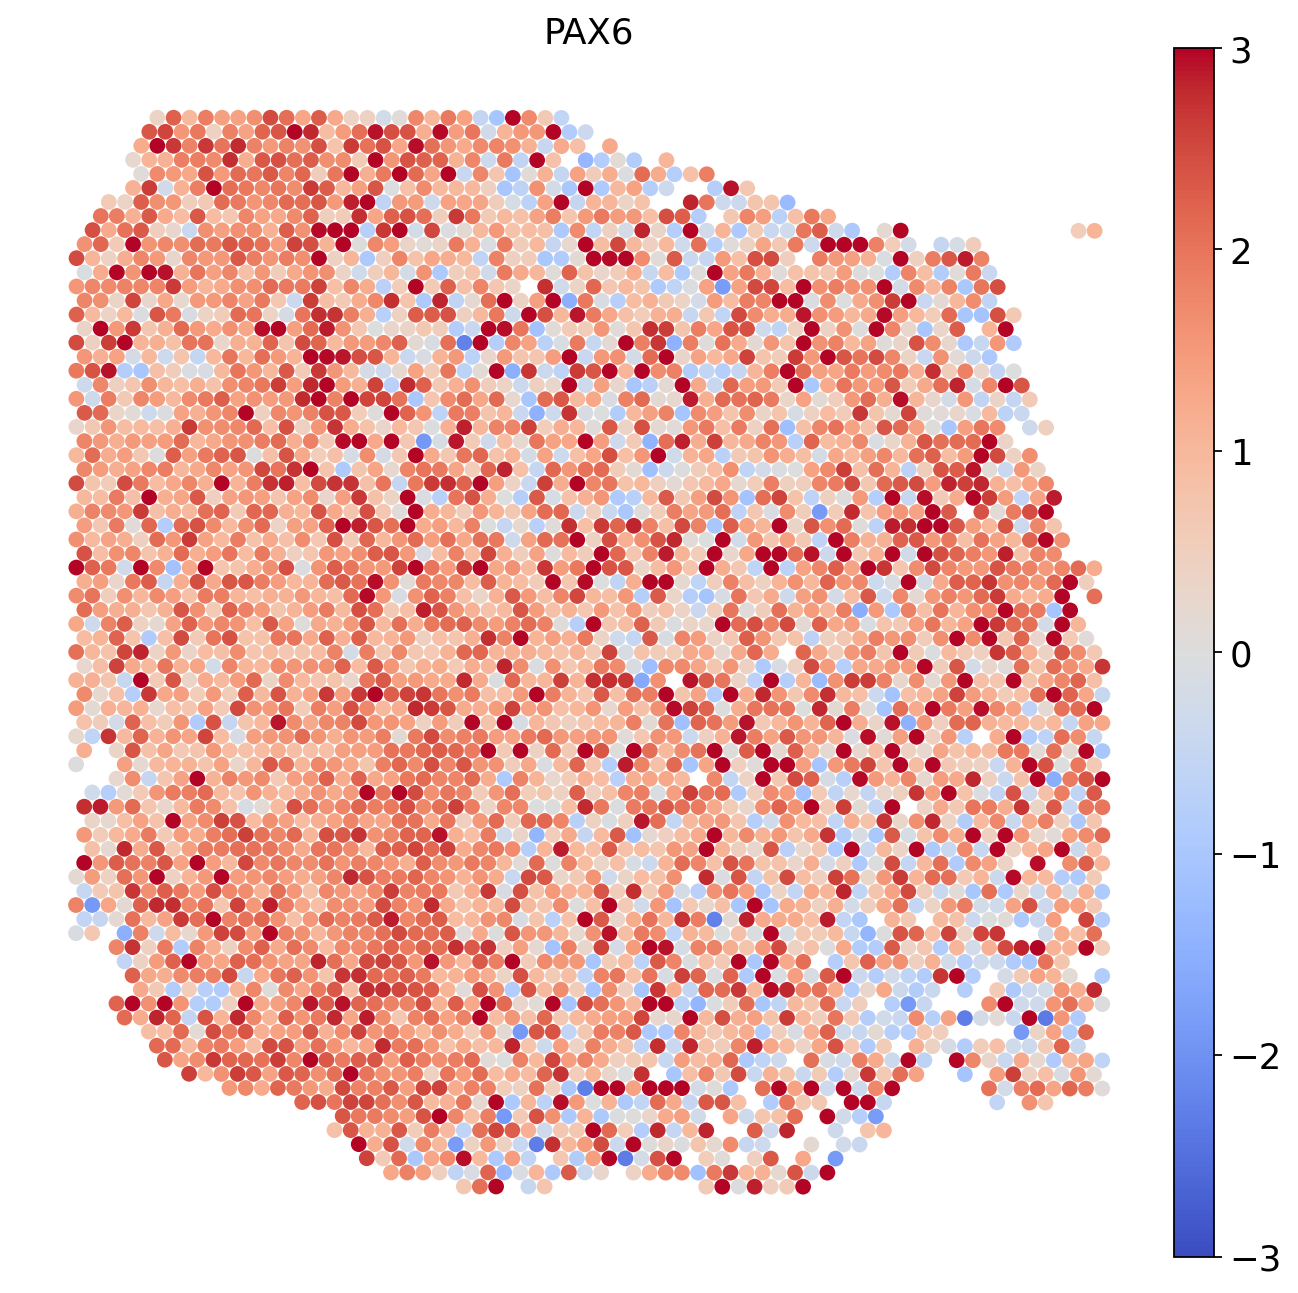

In [49]:
sq.pl.spatial_scatter(mdata.mod['tf'], color=tf, cmap="coolwarm", img=False, size=1.5, vmin=-3, vmax=3)
                      

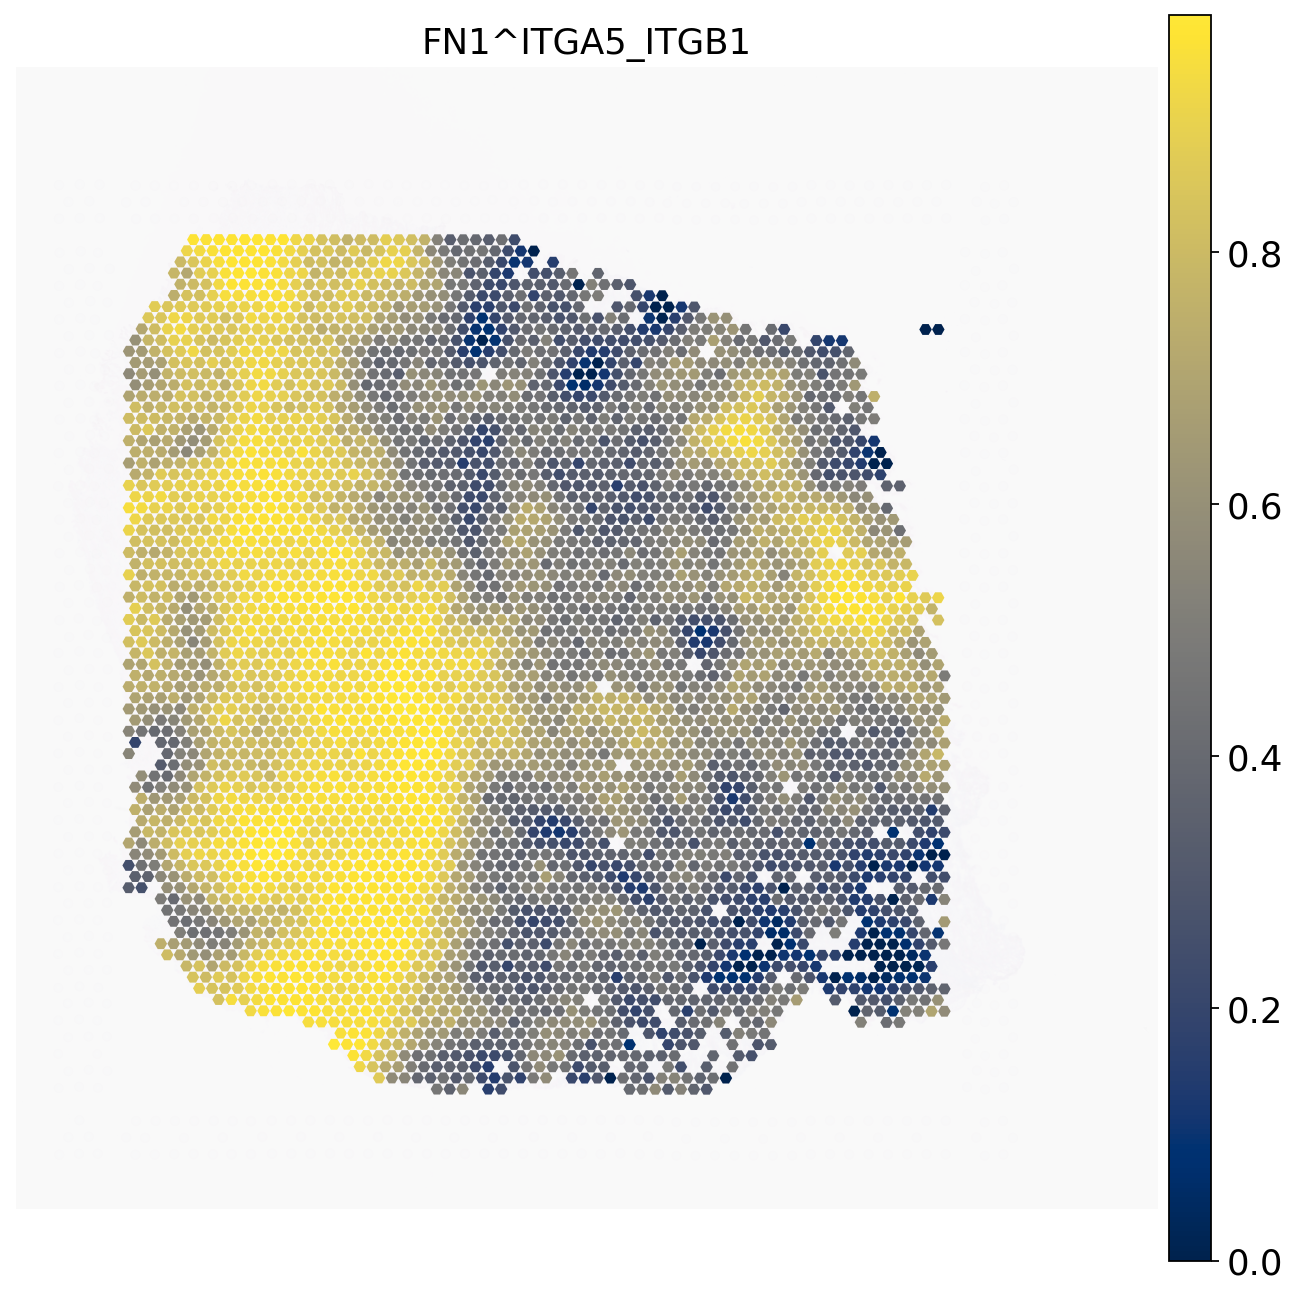

In [50]:
sq.pl.spatial_scatter(mdata.mod['intra'], color=interaction, cmap="cividis", img_alpha=0.05, alpha=1, shape='hex', size=1.5)

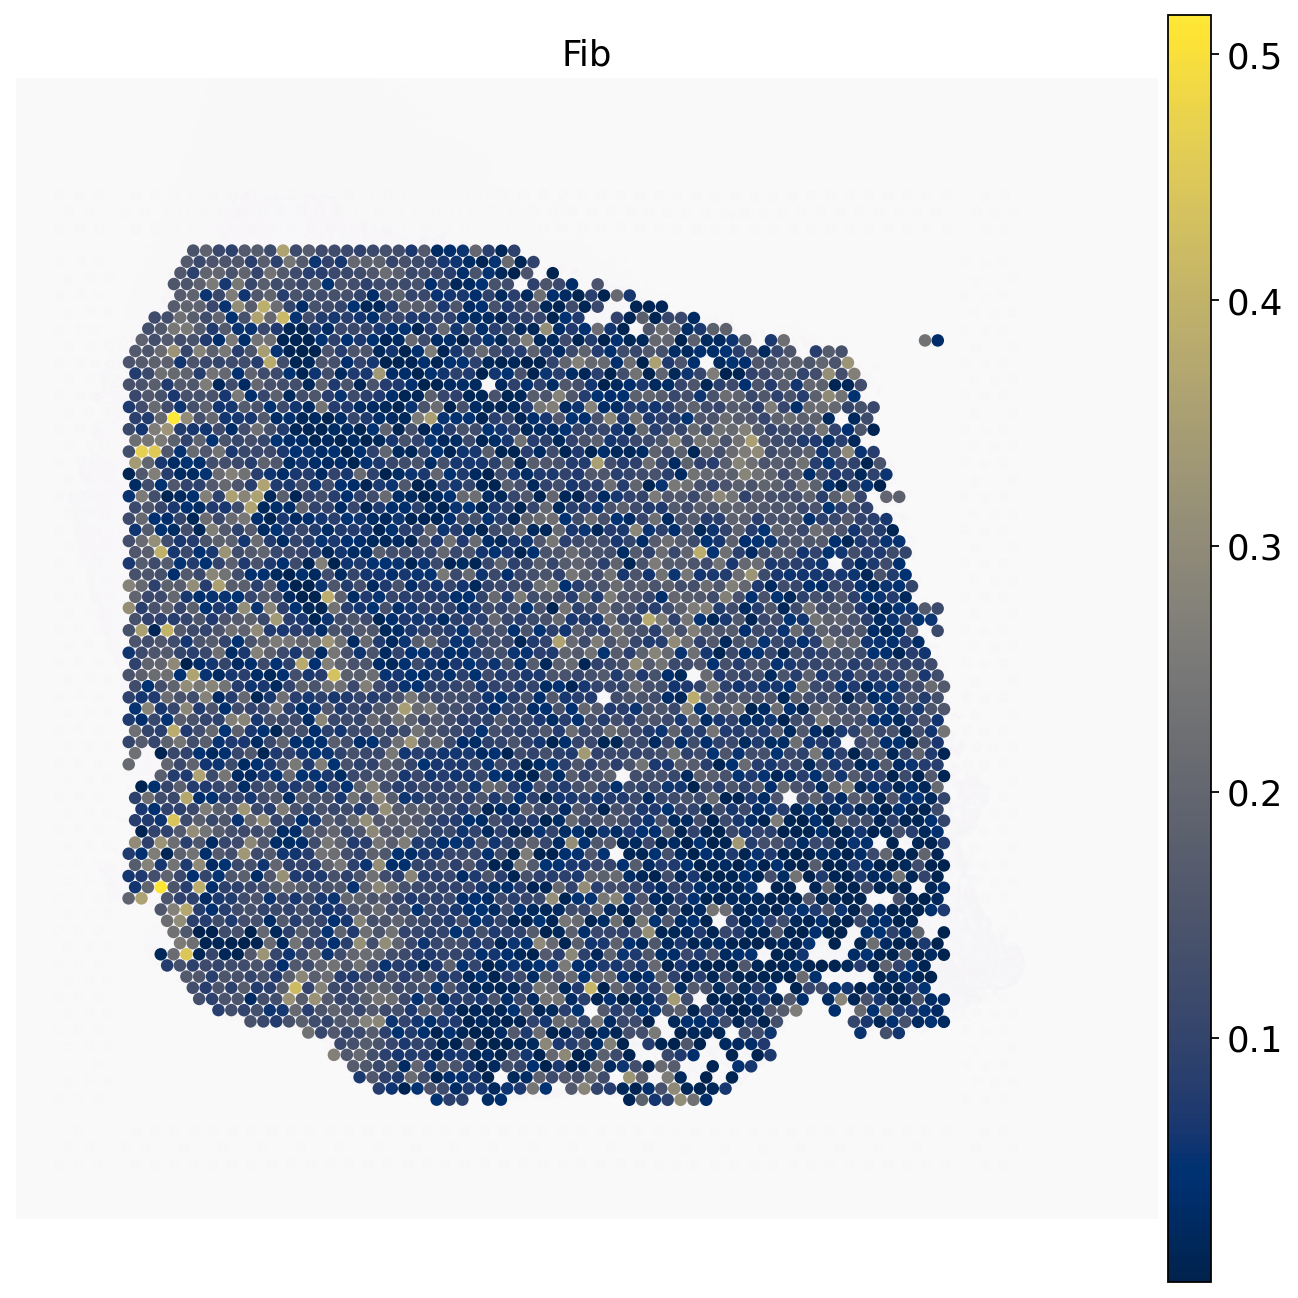

In [51]:
sq.pl.spatial_scatter(mdata.mod['comp'], color='Fib', cmap="cividis", img_alpha=0.05, size=1.5)

BASIS

In [52]:
lrdata = mdata.mod['intra'].copy()

In [53]:
mdata.obsm = lrdata.obsm.copy()
mdata.uns = lrdata.uns.copy()
mdata.obsp = lrdata.obsp.copy()

In [54]:
li.mt.bivar(mdata,
            function_name='cosine',
            x_mod='tf', y_mod='intra',
            x_transform=sc.pp.scale,
            y_transform=sc.pp.scale,
            interactions=[(tf, interaction)],
            positive_only=False, 
            add_categories=True,
            n_perms=100,
            complex_sep=None,
            xy_sep='<->',
            )

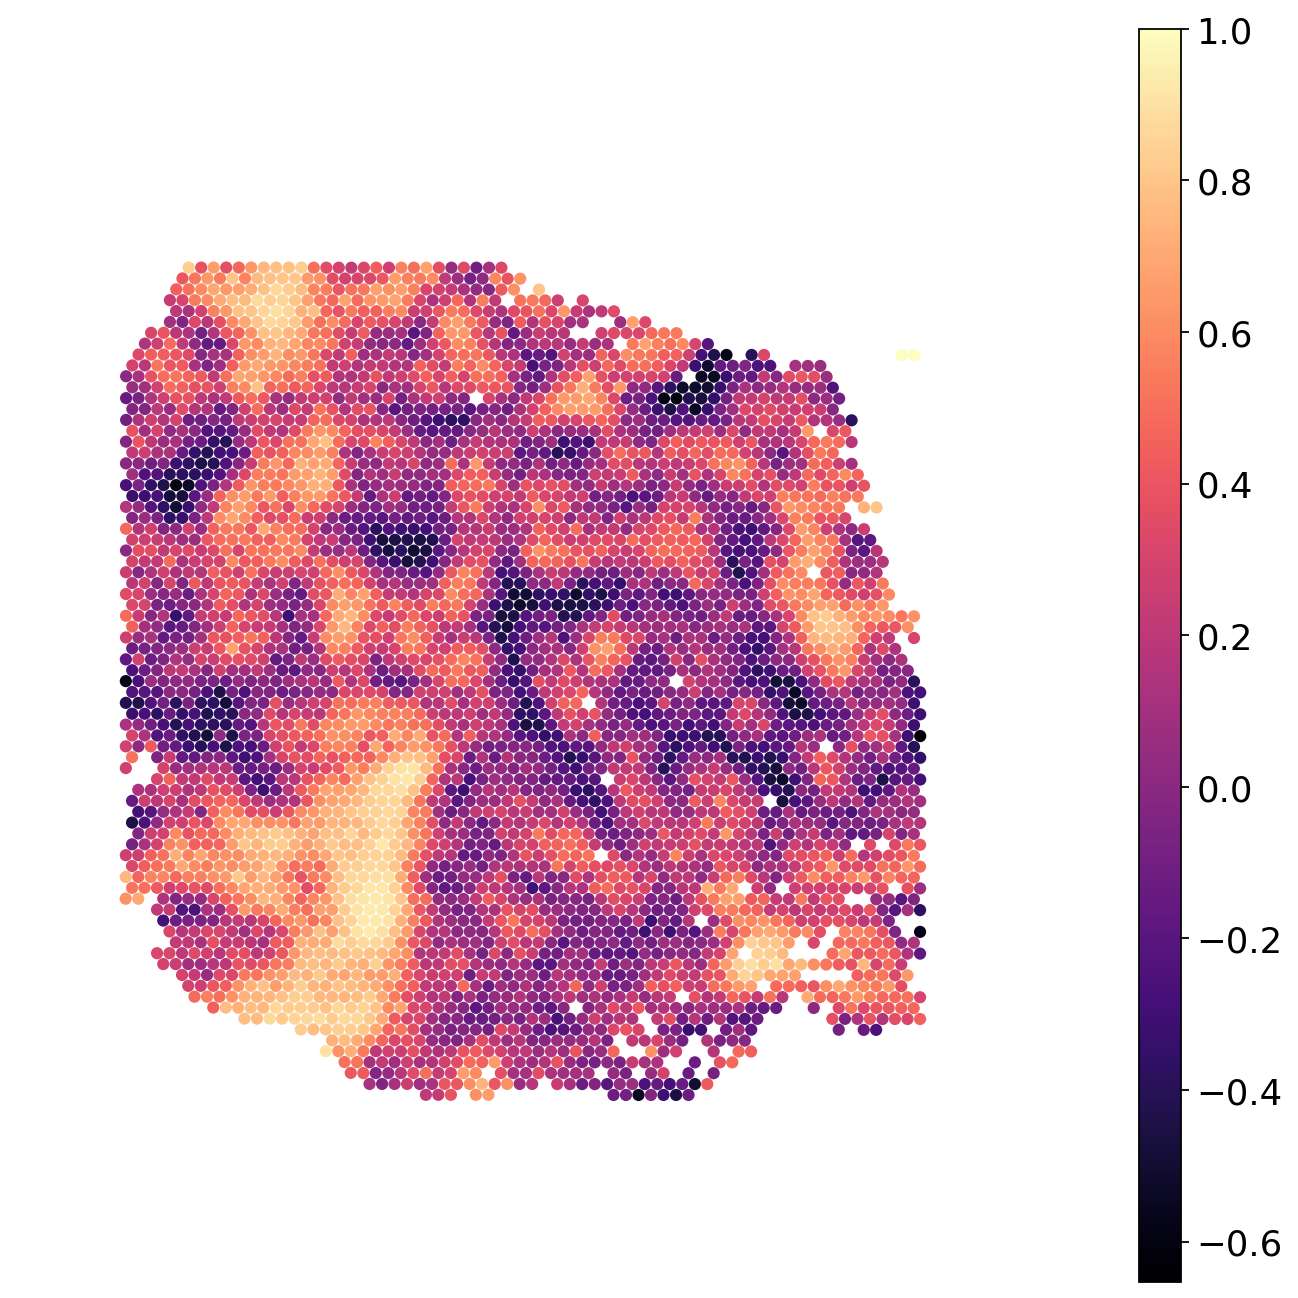

In [55]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=f'{tf}{xy_sep}{interaction}', cmap="magma", img_alpha=0, size=1.5, title="")

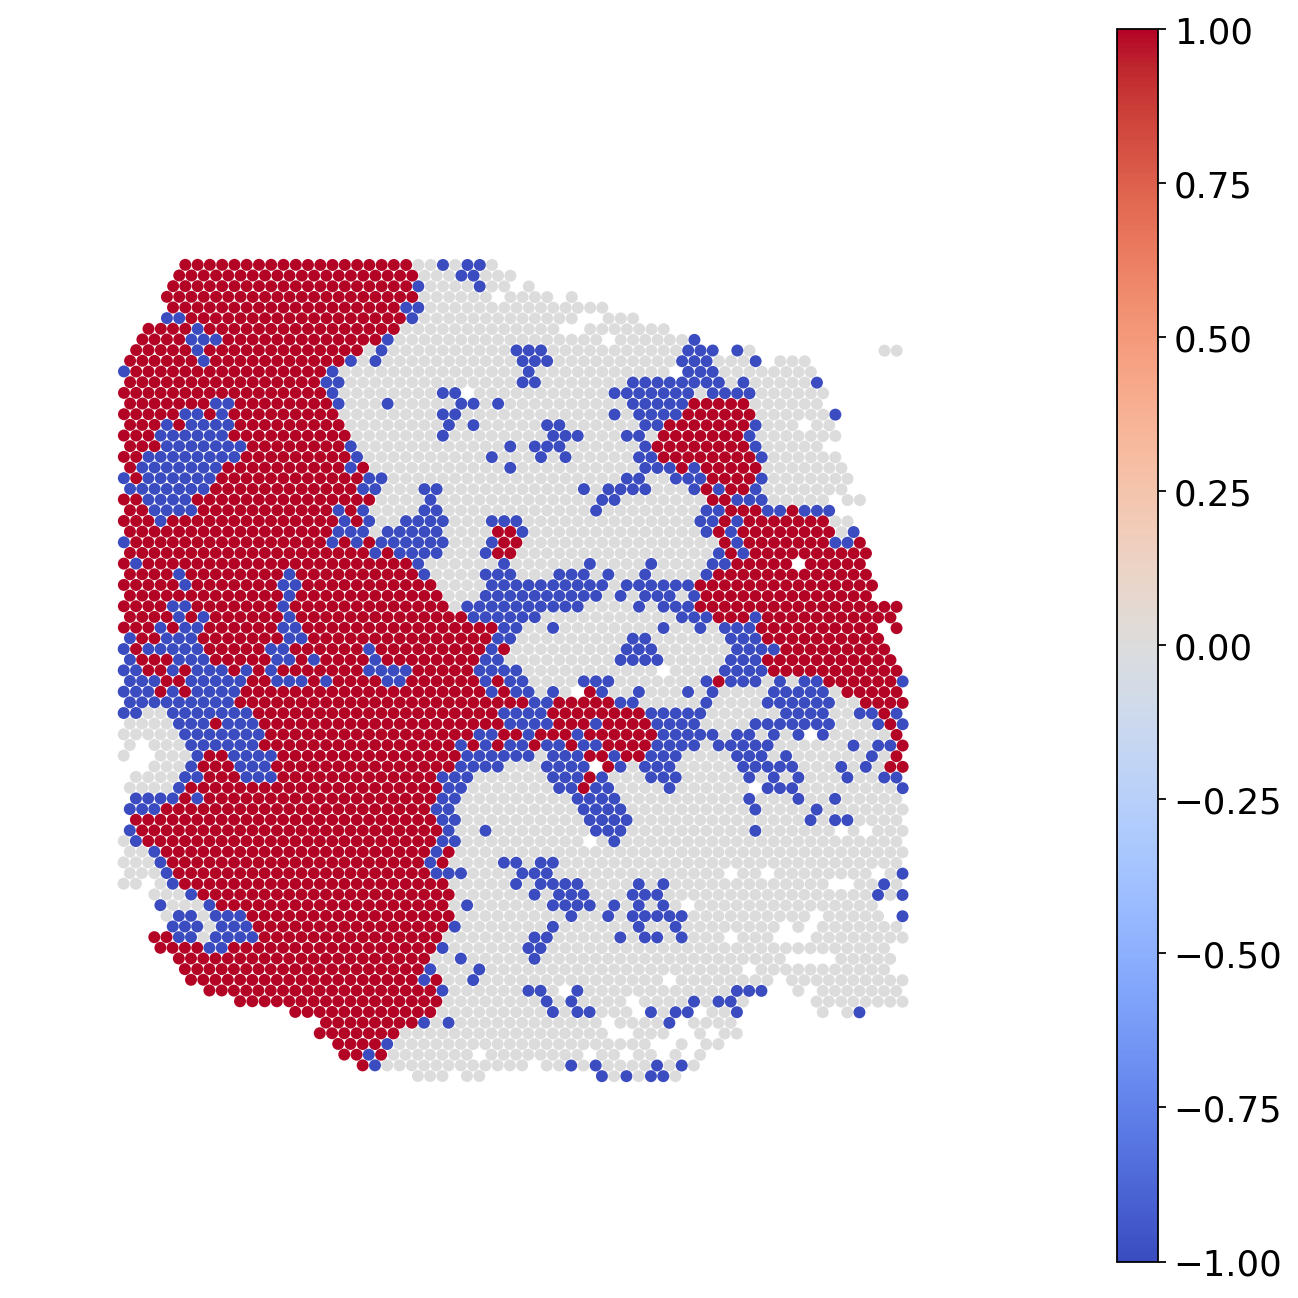

In [56]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], layer='cats', color=f'{tf}{xy_sep}{interaction}', cmap="coolwarm", img_alpha=0, size=1.5, title="")

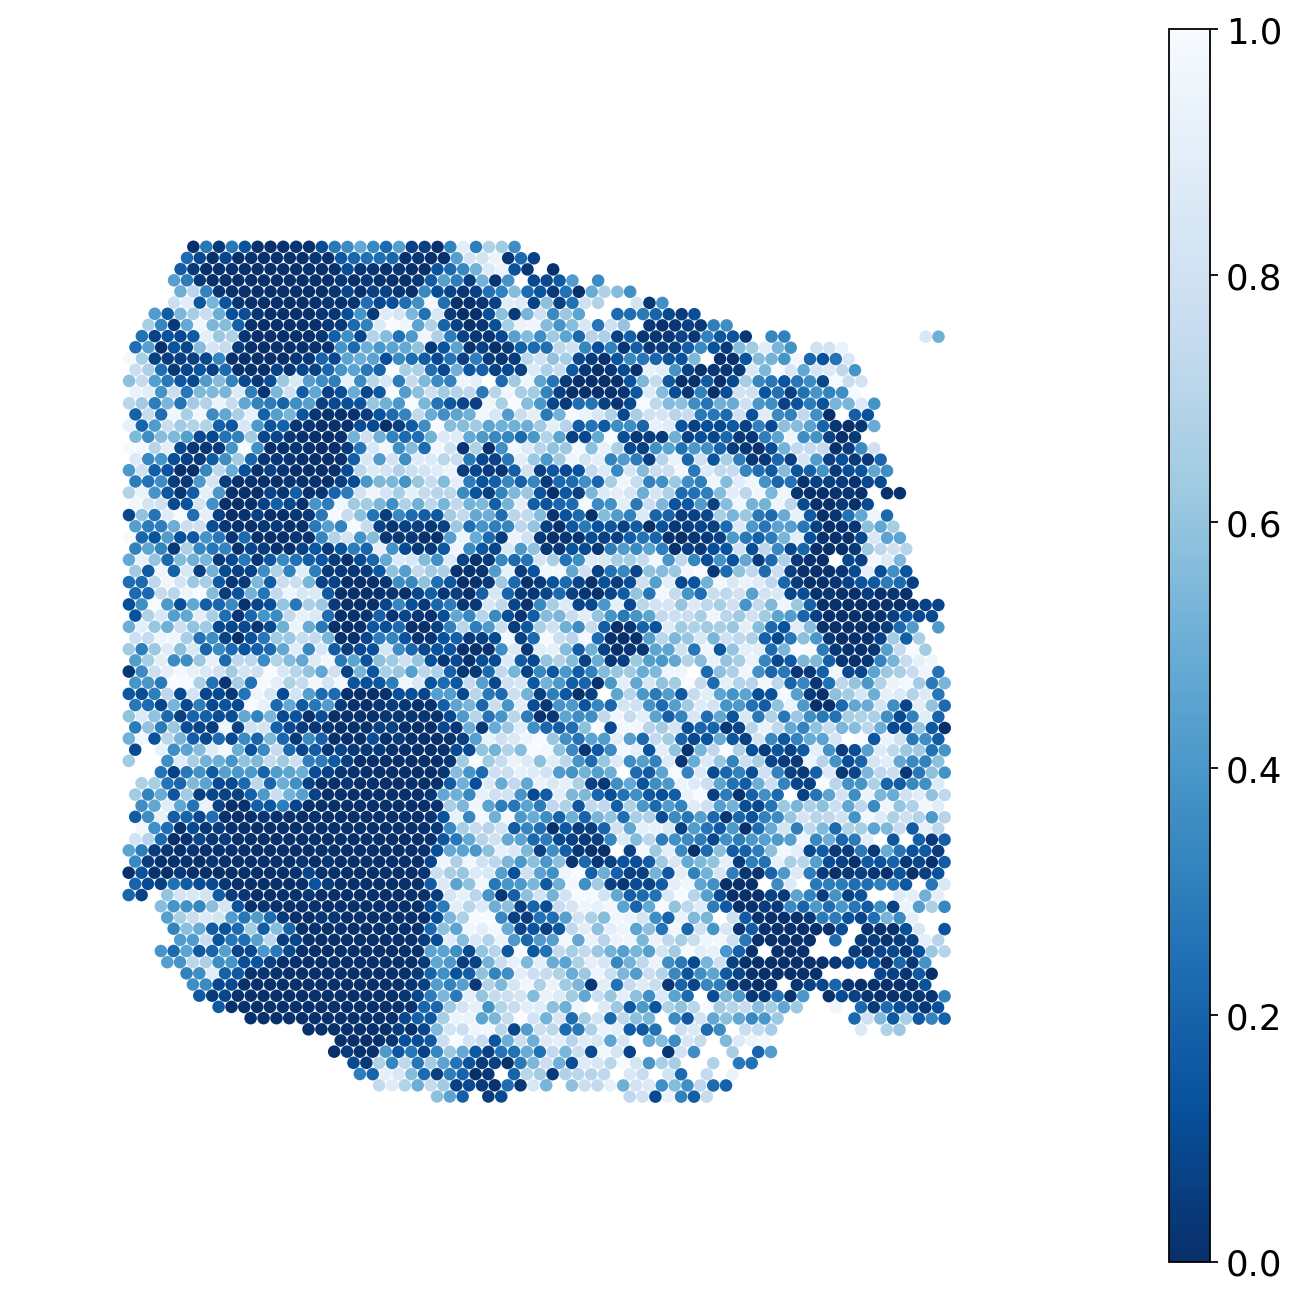

In [60]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], layer='pvals', color=f'{tf}{xy_sep}{interaction}', cmap="Blues_r", img_alpha=0, size=1.5, title="")

In [58]:
nmfdata = sc.read_h5ad(os.path.join('results', 'nmf', slide+'.h5ad'))

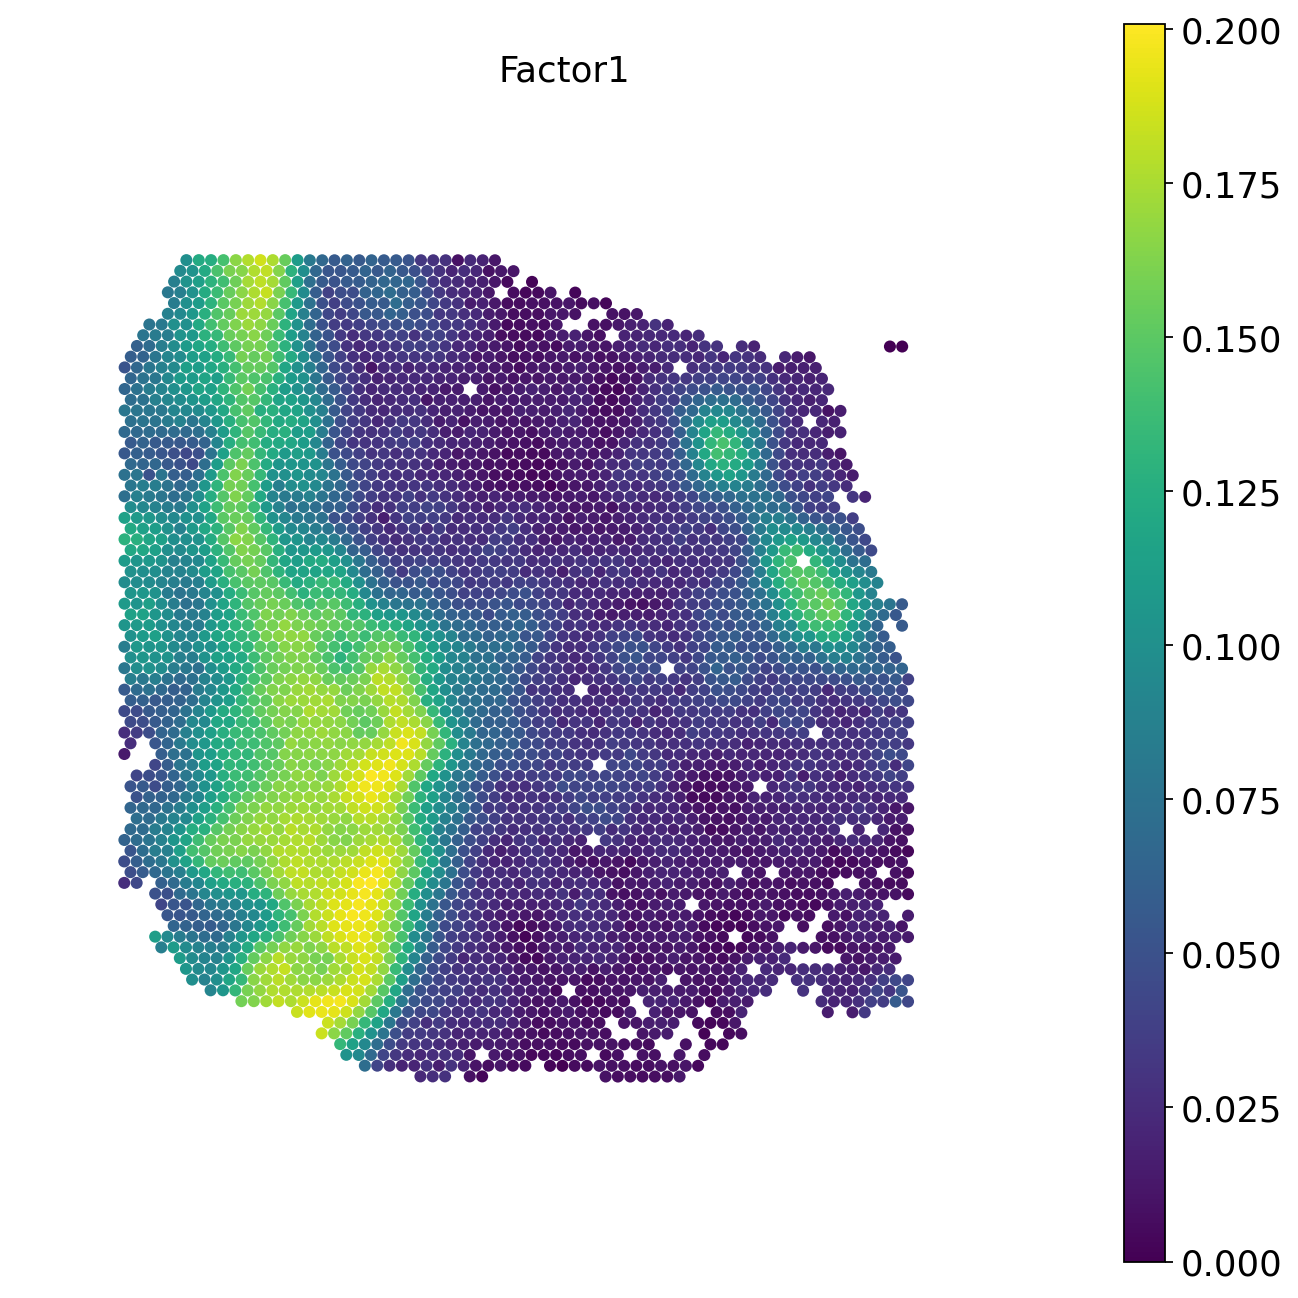

In [59]:
sq.pl.spatial_scatter(nmfdata, color='Factor1', cmap="viridis", img_alpha=0, size=1.5)